### Step-1: Import Libraries

Below cell imports the basic libraries we need:

- NumPy for all linear algebra operations (vectors, matrices, eigenvalues, SVD).
- Pandas to handle the dataset from HuggingFace.
- Matplotlib for visualizations.
- datasets to load the dataset directly from Hugging Face.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset

### Step-2: Load Dataset (HuggingFace)

We load the "full" configuration because it contains daily stock metrics with numeric columns.

This dataset gives us data like price, volume, market cap, PE ratios, etc., which we will convert into matrices.

In [2]:
ds = load_dataset("ronantakizawa/trending-stocks-yahoo-finance", "full")
df = ds["train"].to_pandas()
df.head()

,symbol,name,price,change,change_pct,volume,avg_volume_3m,market_cap,pe_ratio,rank,date
0,NXU,"Nxu, Inc.",1.060,-0.4400,-29.33,72599000.0,16459000.0,1.761700e+07,0.01,1,2025-01-01
1,MSTR,MicroStrategy Incorporated,289.620,-13.3400,-4.40,22226000.0,27339000.0,7.109000e+10,NaN,2,2025-01-01
2,EYEN,"Eyenovia, Inc.",0.146,0.0327,28.86,406414000.0,10536000.0,1.626800e+07,NaN,3,2025-01-01
3,OPTT,"Ocean Power Technologies, Inc.",1.020,0.1400,15.91,170276000.0,31279000.0,1.489600e+08,NaN,4,2025-01-01
4,FNMA,Federal National Mortgage Association,3.280,-0.1200,-3.53,11943000.0,13844000.0,3.799000e+09,NaN,5,2025-01-01


### Step-4: Select Numeric Columns for Linear Algebra

We choose the numeric columns we will treat as a matrix.

These columns represent measurable properties of stocks and form the features of our vectors.

- Each row → a stock on a particular day
- Each column → one numeric feature

In [3]:
numeric_cols = [
    "price",
    "change",
    "change_pct",
    "volume",
    "avg_volume_3m",
    "market_cap",
    "pe_ratio",
    "rank"
]

df_num = df[numeric_cols].dropna()
X = df_num.to_numpy()

X[:5]

array([[ 1.06000e+00, -4.40000e-01, -2.93300e+01,  7.25990e+07,
         1.64590e+07,  1.76170e+07,  1.00000e-02,  1.00000e+00],
       [ 2.80000e+00,  1.43000e+00,  1.04380e+02,  1.15985e+08,
         1.20846e+05,  1.57050e+07,  9.03000e+00,  6.00000e+00],
       [ 1.20000e+00,  1.00000e-01,  9.09000e+00,  3.67270e+07,
         3.72900e+06,  1.05910e+07,  0.00000e+00,  7.00000e+00],
       [ 1.42200e-01,  3.50000e-03,  2.52000e+00,  3.98390e+08,
         1.30710e+07,  9.11200e+06,  0.00000e+00,  1.70000e+01],
       [ 6.26000e+00, -6.30000e-01, -9.14000e+00,  5.76700e+06,
         2.03700e+06,  1.70801e+08,  1.07900e+01,  1.80000e+01]])

### Step-4: Center the Matrix (X − mean)

Before computing covariance, PCA, or SVD, we center the dataset by subtracting the mean of each column.

This avoids incorrect covariance and gives more meaningful eigenvectors.


#### Intuition:

What we are doing:
- Subtract the mean of each feature.

Why:
- This removes “offset” in features and allows covariance, PCA, SVD to focus on variation, not absolute values.

Meaning:
- We shift everything so the “average stock” sits at the origin.
- This makes comparisons fair.

#### Standardization
- PCA is sensitive to the scale of features.
- In our dataset, some features (like market_cap and volume) have extremely large values compared to features like change_pct or pe_ratio.
- If we run PCA on raw values, components will be dominated by large-scale features and the results may not reflect true relationships in the data.

Standardizing each feature to zero mean and unit variance ensures:
- all features contribute equally
- PCA focuses on patterns, not raw magnitudes
- scree plot and PCA visualization become easier to interpret
Below, we standardize the matrix 𝑋 before computing covariance, eigenvalues, and PCA.

In [4]:
mean_vec = np.mean(X, axis=0)
X_centered = X - mean_vec
display(X_centered[:5])

# Standardize the data: zero mean and unit variance for each column
std_vec = np.std(X, axis=0)

# Avoid division-by-zero
std_vec[std_vec == 0] = 1.0

X_standardized = (X - mean_vec) / std_vec

display(X_standardized[:5])


array([[-3.62006095e+03, -3.90580360e+00, -2.08317001e+02,
         4.46148331e+07, -3.38179010e+06, -7.32561431e+11,
        -6.74832552e+01, -1.16293662e+01],
       [-3.61832095e+03, -2.03580360e+00, -7.46070006e+01,
         8.80008331e+07, -1.97199441e+07, -7.32563343e+11,
        -5.84632552e+01, -6.62936624e+00],
       [-3.61992095e+03, -3.36580360e+00, -1.69897001e+02,
         8.74283309e+06, -1.61117901e+07, -7.32568457e+11,
        -6.74932552e+01, -5.62936624e+00],
       [-3.62097875e+03, -3.46230360e+00, -1.76467001e+02,
         3.70405833e+08, -6.76979010e+06, -7.32569936e+11,
        -6.74932552e+01,  4.37063376e+00],
       [-3.61486095e+03, -4.09580360e+00, -1.88127001e+02,
        -2.22171669e+07, -1.78037901e+07, -7.32408247e+11,
        -5.67032552e+01,  5.37063376e+00]])

array([[-7.32622497e-02, -4.21959999e-03, -1.71181616e-02,
         6.85454854e-01, -8.02928749e-02, -4.61984333e-02,
        -3.34653700e-01, -1.59199444e+00],
       [-7.32270358e-02, -2.19936222e-03, -6.13072714e-03,
         1.35203012e+00, -4.68204992e-01, -4.61985539e-02,
        -2.89922954e-01, -9.07522729e-01],
       [-7.32594164e-02, -3.63621582e-03, -1.39610512e-02,
         1.34323429e-01, -3.82537624e-01, -4.61988764e-02,
        -3.34703291e-01, -7.70628387e-01],
       [-7.32808240e-02, -3.74046873e-03, -1.45009318e-02,
         5.69085344e+00, -1.60733190e-01, -4.61989697e-02,
        -3.34703291e-01,  5.98315032e-01],
       [-7.31570128e-02, -4.42486479e-03, -1.54590762e-02,
        -3.41340847e-01, -4.22710296e-01, -4.61887729e-02,
        -2.81195003e-01,  7.35209374e-01]])

### Step-5: Compute Covariance Matrix

The sample covariance matrix $\mathbf{C}$ can be calculated using the following equation:

$$\mathbf{C} = \frac{1}{n-1} \mathbf{X}^\top \mathbf{X}$$

Where:
* $n$ is the number of samples (observations).
* $\mathbf{X}$ is the data matrix, where each row is a sample and each column is a mean-centered variable.
* $\mathbf{X}^\top$ is the transpose of the mean-centered data matrix.

#### Intuition:

What we are doing:
- We compute how each pair of features varies together.

Examples:
- Does high price correlate with high market cap?
- Do high volume stocks tend to change percentage more?

Why:
- Covariance tells us relationships between features.

Meaning:
- We learn which stock characteristics move together.
- This alone can tell a user what factors are connected in trending stocks.

In [5]:
n_samples = X_standardized.shape[0]
C = (X_standardized.T @ X_standardized) / (n_samples - 1)
C

array([[ 1.00006973e+00,  5.90770725e-02, -1.06167050e-03,
        -3.02456574e-02, -3.29822618e-02,  3.92285466e-03,
        -1.94634253e-02,  1.28715038e-02],
       [ 5.90770725e-02,  1.00006973e+00,  7.82588193e-04,
        -2.70037205e-03, -2.17023848e-03, -5.45228627e-03,
         5.11323706e-04,  8.61470954e-03],
       [-1.06167050e-03,  7.82588193e-04,  1.00006973e+00,
        -5.39450928e-03, -6.88067519e-03, -6.84873639e-04,
        -4.03681821e-03, -1.97935842e-02],
       [-3.02456574e-02, -2.70037205e-03, -5.39450928e-03,
         1.00006973e+00,  6.17710489e-01,  9.70479048e-02,
         1.49243552e-03, -1.57205841e-01],
       [-3.29822618e-02, -2.17023848e-03, -6.88067519e-03,
         6.17710489e-01,  1.00006973e+00,  8.38137913e-02,
         3.20022555e-02, -1.69507959e-01],
       [ 3.92285466e-03, -5.45228627e-03, -6.84873639e-04,
         9.70479048e-02,  8.38137913e-02,  1.00006973e+00,
        -7.45345115e-03,  4.08317321e-03],
       [-1.94634253e-02,  5.113237

### Step-6: Eigenvalues & Eigenvectors of Covariance Matrix

The eigenvalues tell us how much variation each direction explains.

The eigenvectors tell us the directions (principal components).

We sort them largest → smallest.

#### Intuition:

What we are doing:
- We compute eigenvalues and eigenvectors of the covariance matrix.

Why:
- Eigenvalues: how much variation exists in each major direction
- Eigenvectors: what those directions are (combinations of features)

This is the beginning of PCA.

Meaning:
- We find the “important” directions in which the data spreads.
- (In other words) What are the dominant patterns in trending stocks?

In [6]:
# Eigen Value Decomposition - identifying eigen values and eigen vectors of matrix C
eigvals, eigvecs = np.linalg.eigh(C)

# sort in descending order
idx = np.argsort(eigvals)[::-1]
display(idx)
eigvals = eigvals[idx]
# Arrange Eigen Vectors in order of idx (descending index)
eigvecs = eigvecs[:, idx]

display(eigvals)
display(eigvecs)

array([7, 6, 5, 4, 3, 2, 1, 0])

array([1.71971214, 1.06305099, 1.03153129, 1.00323146, 0.97456035,
       0.94145576, 0.88562951, 0.38138629])

array([[-6.51931397e-02, -6.60949194e-01, -2.09419543e-01,
         1.11638983e-03,  1.56484149e-02,  6.95047433e-01,
         1.78041482e-01, -1.91020159e-03],
       [-1.46681512e-02, -6.15470059e-01, -3.84479912e-01,
        -8.77590918e-02,  3.69635633e-02, -6.61899325e-01,
        -1.61174868e-01,  7.94965879e-04],
       [-3.28320821e-03,  4.88630995e-02, -2.23067573e-01,
         9.36352537e-01,  1.94589369e-01, -7.00442044e-02,
         1.68260431e-01, -1.90165049e-03],
       [ 6.59799805e-01, -7.38489537e-02,  6.53166869e-02,
        -1.68060316e-03, -8.51586281e-02, -4.10597682e-02,
         2.19630059e-01,  7.05525475e-01],
       [ 6.62261639e-01, -5.04248705e-02,  2.13213635e-02,
        -1.94317658e-02, -7.30140973e-02, -3.72854849e-02,
         2.24888396e-01, -7.07628860e-01],
       [ 1.63619496e-01, -2.17338463e-01,  4.94603903e-01,
         4.73656734e-02,  7.33147569e-01,  3.69343552e-02,
        -3.74221879e-01, -1.43040678e-02],
       [ 5.06556650e-02,  3.161308

### Step-7: Scree Plot (Eigenvalue Visualization)

A scree plot shows how much each eigenvalue contributes to total variance.

This helps decide how many principal components to keep.

#### Intuition:

What we are doing:
- Plotting eigenvalues in descending order.

Why:
- To see which components matter most.

Meaning:
- Shows how many “real patterns” exist in the data.
- (Example:) “If the first 2 eigenvalues are huge and rest are tiny → data is 2D in structure.”

This tells a user:
- “How complex is this dataset actually?”

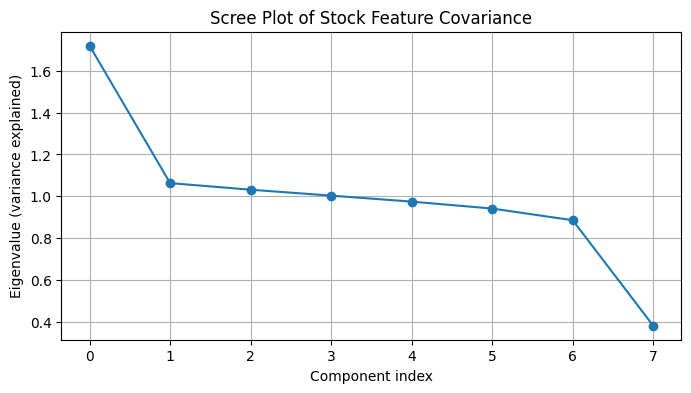

In [7]:
plt.figure(figsize=(8,4))
plt.plot(eigvals, marker='o')
plt.xlabel("Component index")
plt.ylabel("Eigenvalue (variance explained)")
plt.title("Scree Plot of Stock Feature Covariance")
plt.grid(True)
plt.show()

### Step-8: Principal Component Analysis (PCA)

#### Project Data onto First 2 Principal Components

The projection of the mean-centered data onto the new principal components is given by:

$$\mathbf{X}_{\text{proj}} = \mathbf{X}_{\text{standardized}} \mathbf{V}_{k}$$

Where:
* $\mathbf{X}_{\text{proj}}$ is the data in the reduced dimension space.
* $\mathbf{X}_{\text{standardized}}$ is the original data matrix (rows are samples, columns are mean-centered features).
* $\mathbf{V}_{k}$ are the first $k$ eigenvectors (principal components) of the covariance matrix.

This method can, for example, reduce data from $8$ dimensions to $2$ dimensions while keeping most of the original information (variance).

#### Intuition:

What we are doing:
- We take the first 2 eigenvectors and project data onto them.

Why:
- To compress data while preserving the most important variation.
- This is dimensionality reduction.

Meaning:
- We turn many features into 2 features that capture the primary trends.
- This lets users see structure in the stock market that isn't visible in the raw data.

PCA helps answer:
- Are trending stocks forming groups?
- Are some stocks extreme outliers?

#### Note:

The `@` vs. `*` Operators in NumPy (Matrix Multiplication)

In NumPy, these two operators have distinct mathematical meanings.

| Operator | Python Syntax | Mathematical Action | Description |
| :---: | :---: | :--- | :--- |
| `*` | `A * B` | Element-wise Multiplication (Hadamard Product) | Multiplies corresponding elements of two arrays/matrices, which must have compatible shapes. |
| **`@`** | **`A @ B`** | **Matrix Multiplication (Dot Product)** | Performs the standard linear algebra operation $\mathbf{A}\mathbf{B}$. The inner dimensions of the matrices must match (e.g., $m \times \mathbf{n}$ and $\mathbf{n} \times p$). |

---
**Example:** The PCA Projection, $\mathbf{X}_{\text{proj}} = \mathbf{X}_{\text{centered}} \mathbf{V}_{k}$, must use the matrix multiplication operator:

```python
X_pca = X_standardized @ V_k

In [8]:
V2 = eigvecs[:, :2]      # first 2 eigenvectors
X_pca2 = X_standardized @ V2 # projection


X_pca2[:5]

array([[ 0.86302982,  0.16840147],
       [ 0.84023051,  0.04012745],
       [ 0.04972174,  0.08969689],
       [ 3.44700827, -0.55581867],
       [-0.74539327, -0.1023352 ]])

### Step-9: Scatter Plot of PCA (2D Map of Stocks)

This shows how stocks relate to each other in the new 2-D “information space”.

Clusters represent stocks with similar numerical behaviors.

#### Intuition:

What we are doing:
- Plot the projected data points in 2D.

Why:
- To visualize clusters and patterns.

Meaning:
- This gives users an intuitive “map” of trending stocks:
- Which stocks behave similarly
- Which features drive separation
- Whether trending stocks naturally cluster by volatility, size, etc.
- This is one of the most useful, interpretable outputs.

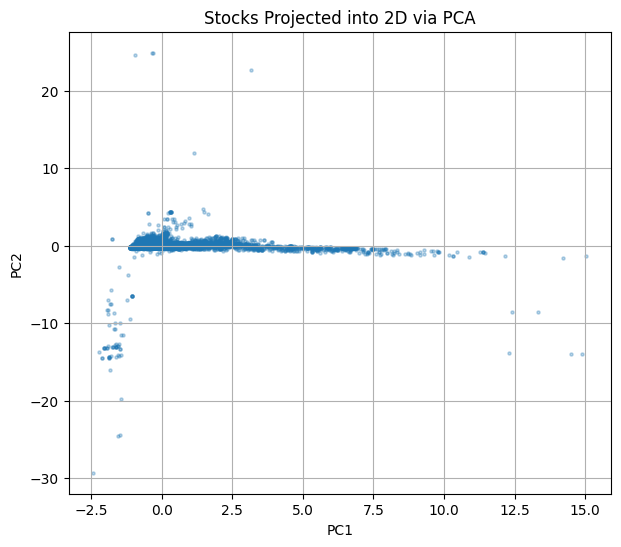

In [9]:
plt.figure(figsize=(7,6))
plt.scatter(X_pca2[:,0], X_pca2[:,1], s=5, alpha=0.3)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Stocks Projected into 2D via PCA")
plt.grid(True)
plt.show()

### Step-10: Singular Value Decomposition (SVD)

#### Perform SVD on Centered Matrix

Any matrix $\mathbf{X}$ can be decomposed into three component matrices using the Singular Value Decomposition:

$$\mathbf{X} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^{\top}$$



Where:
* $\mathbf{X}$ is the original $m \times n$ data matrix.
* $\mathbf{U}$ is an $m \times m$ orthogonal matrix of the left singular vectors.
* $\mathbf{\Sigma}$ is an $m \times n$ diagonal matrix containing the singular values.
* $\mathbf{V}^{\top}$ is the transpose of an $n \times n$ orthogonal matrix of the right singular vectors.

SVD is incredibly useful for:

* **Compressing Data:** By setting the smaller singular values in $\mathbf{\Sigma}$ to zero.
* **Analyzing Structure:** The singular values indicate the "importance" of each dimension/factor.
* **Computing Low-Rank Approximations:** Used in tasks like recommender systems and noise reduction.

#### Intuition:

What we are doing:
- Factor the centered matrix into SVD equation shown above:

Why we use SVD here:
- Even after PCA, SVD gives a clearer view of how many important patterns the data truly has and how much each contributes. It also enables low-rank approximations, where we keep only the strongest patterns to simplify or denoise the dataset.

Meaning for the user:
- SVD shows the “importance spectrum” of the data. By looking at the singular values, users can quickly understand whether the dataset is mostly low-rank (few strong patterns) or complex (many medium-strength patterns).

Note:
- Compare the magnitudes of the singular values obtained from S in below code block. If the first few singular values are much larger than the rest, the dataset behaves as effectively low-rank which means it is dominated by a few strong underlying patterns, while the remaining components contribute very little and mostly represent minor variation or noise.

In [10]:
U, S, Vt = np.linalg.svd(X_standardized, full_matrices=False)

S[:10]  # first 10 singular values

array([157.04811859, 123.4758167 , 121.63149993, 119.95143028,
       118.22497453, 116.19964951, 112.70181214,  73.95838104])

### Step-11: Low-Rank Approximation (SVD Truncation) [Rank - 2]

To create a rank-$k$ approximation of the original data matrix $\mathbf{X}$ (denoted $\mathbf{X}_k$), we truncate the SVD matrices by keeping only the top $k$ singular values and their corresponding vectors. If we set $k=2$, the approximation is:

$$\mathbf{X}_{(2)} = \mathbf{U}_{(2)} \mathbf{\Sigma}_{(2)} \mathbf{V}_{(2)}^{\top}$$



This equation keeps only the top $2$ singular values (the strongest patterns) in $\mathbf{\Sigma}$, which results in:
* A significantly smaller matrix $\mathbf{X}_{(2)}$ that captures the majority of the variance in the original data $\mathbf{X}$.
* Data compression and noise reduction by discarding the components associated with small singular values.

#### Intuition:

Why:
- To see how well the dataset can be explained with only a few important patterns.

Meaning:
- “This entire dataset can be approximated using only 2 main factors.”
- For a user, this is powerful as it shows the data is not random and it has a structure.

In [11]:
k = 2  # rank
U_k = U[:, :k]
S_k = np.diag(S[:k])
Vt_k = Vt[:k, :]

X_approx = U_k @ S_k @ Vt_k

X_approx[:5]

array([[-1.67568438e-01, -1.16305113e-01,  5.39511109e-03,
         5.56990637e-01,  5.63059923e-01,  1.04608388e-01,
         9.69542570e-02, -2.89700315e-01],
       [-8.12994696e-02, -3.70218708e-02, -7.97900256e-04,
         5.51420560e-01,  5.54429016e-01,  1.28756855e-01,
         5.52479615e-02, -2.61782042e-01],
       [-6.25266004e-02, -5.59350733e-02,  4.21962101e-03,
         2.61823726e-02,  2.84058465e-02, -1.13591373e-02,
         3.08746447e-02, -2.97823229e-02],
       [ 1.42646608e-01,  2.91528509e-01, -3.84762687e-02,
         2.31538201e+00,  2.31084843e+00,  6.84798530e-01,
        -1.10095882e-03, -9.56043141e-01],
       [ 1.16232895e-01,  7.39177922e-02, -2.55313372e-03,
        -4.84252986e-01, -4.88485128e-01, -9.97194958e-02,
        -7.01097102e-02,  2.43156635e-01]])

### Step-12: Reconstruction Error (Relative)

The **relative reconstruction error** measures the quality of a low-rank approximation $\mathbf{X}_{\text{approx}}$ (like $\mathbf{X}_{(k)}$ from SVD) compared to the original matrix $\mathbf{X}$. It is calculated as:

$$\text{Error} = \frac{\Vert \mathbf{X} - \mathbf{X}_{\text{approx}} \Vert}{\Vert \mathbf{X} \Vert}$$

Where:
* $\mathbf{X}$ is the same matrix used during SVD. (in our case, the standardized matrix).
* $\mathbf{X}_{\text{approx}}$ (or $\mathbf{X}_k$) is the low-rank approximation of $\mathbf{X}$.
* $\Vert \cdot \Vert$ represents the **Frobenius Norm** of the matrix, defined as $\Vert \mathbf{A} \Vert = \sqrt{\sum_{i=1}^m \sum_{j=1}^n |a_{ij}|^2}$.



A smaller error value indicates that the approximation $\mathbf{X}_{\text{approx}}$ retains more of the original information in $\mathbf{X}$.

#### Intuition:

What we are doing:
- Measure how much information is lost when using only rank 2.

Why:
- To evaluate how well our low-dimensional model represents reality.

Meaning:
- If error is small → the dataset is mostly driven by a few patterns.
- If large → the dataset is complex and cannot be reduced easily.
- This tells the user: “How much of the stock behavior can be explained with simple linear patterns?”

### Note:

- High reconstruction error (example ~0.81) indicates that the dataset is not well-approximated by only two components. While PCA helps visualize the major directions of variation, the data contains multiple meaningful factors and is not strongly low-rank.
- ≤ 0.3 error (good compression)
- ≤ 0.2 error (very good)

In [12]:
error = np.linalg.norm(X_standardized - X_approx) / np.linalg.norm(X_standardized)
error

np.float64(0.8075759160806929)

### Step-13: Linear Regression via Least Squares (Ax = b)

#### Problem Setup

We want to explain (and later predict) **percentage price change (`change_pct`)** as a linear combination of observable market features:

- price
- volume
- market capitalization
- P/E ratio
- rank

#### 📉 The Linear Regression Model

Mathematically, this assumes that the target variable ($\text{change\_pct}$) can be approximated as a linear combination of the explanatory variables ($x_1$ through $x_5$) plus an intercept ($\beta_0$):

$$\text{change\_pct} \approx \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_5 x_5$$

This is a classic **Multiple Linear Regression** problem.

---

#### Why Least Squares?

In real-world data, the linear system formulation $\mathbf{A}\mathbf{x} = \mathbf{b}$ often represents an **overdetermined system**:

$$\mathbf{A}\mathbf{x} = \mathbf{b}$$

This system has **more equations than unknowns** (many data points, few features), meaning an exact solution does not exist.

Instead, we find the coefficient vector $\mathbf{x}$ that minimizes the total squared prediction error, which is the definition of the Least Squares method:

$$\min_{\mathbf{x}} \Vert \mathbf{A}\mathbf{x} - \mathbf{b} \Vert^2$$



The unique **closed-form solution** that achieves this minimum error is known as the **Normal Equation**:

$$\mathbf{x} = (\mathbf{A}^\top \mathbf{A})^{-1} \mathbf{A}^\top \mathbf{b}$$

---

#### What Each Term Represents

- **A (design matrix)**  
  Each row = one observation  
  Each column = one feature (price, volume, etc.)

- **b (target vector)**  
  Observed percentage price changes (`change_pct`)

- **x (coefficients)**  
  Learned weights showing how each feature influences `change_pct`

- **Bias / Intercept**  
  Captures average movement not explained by the features

---

#### Geometric Interpretation (Important)

Least squares **projects `b` onto the column space of `A`**.

- The model prediction is the *closest possible* linear approximation to `b`
- The residual (error) is orthogonal to all feature directions

---

#### Why This Step Is Useful

This step:
- Quantifies how each market feature relates to price movement
- Provides a **baseline explanatory model**
- Reveals whether any linear signal exists at all

This is **not a trading model** but is a sanity check and learning tool.

If there is no signal here, more complex models are unlikely to help.


In [13]:
# Select explanatory variables (features) and target
features = ["price", "volume", "market_cap", "pe_ratio", "rank"]
target = "change_pct"

# Drop rows with missing values to avoid invalid math
df_lr = df[features + [target]].dropna()

# Design matrix A: each column is a feature, each row is one observation
A = df_lr[features].to_numpy()

# Target vector b: observed percentage price changes
b = df_lr[target].to_numpy()

# Add bias (intercept) term by appending a column of ones
# This allows the model to learn a baseline drift
ones = np.ones((A.shape[0], 1))
A_aug = np.hstack([A, ones])

# Solve the least-squares problem: minimize ||Ax - b||²
# This finds the best linear approximation to change_pct
x_hat = np.linalg.lstsq(A_aug, b, rcond=None)[0]

# x_hat contains:
# [coeff_price, coeff_volume, coeff_market_cap, coeff_pe, coeff_rank, intercept]
x_hat


array([ 3.04043939e-06,  1.32114372e-07, -7.17721979e-14,  4.26954554e-02,
        6.52184516e-04,  5.46519774e-05])

### Step-14: Interpretation of Coefficients

This step maps each learned coefficient back to its corresponding feature name.

It shows:
- the **direction** (positive / negative) of each feature’s effect on `change_pct`
- the **intercept (bias)**, representing baseline movement not explained by features

This makes the regression output interpretable instead of a raw numeric vector.

In [14]:
# Create a list of names for each coefficient
# The last one is "bias" because we added an intercept column earlier
feature_names = features + ["bias"]

# Loop through each coefficient using its index
for i in range(len(x_hat)):
    feature_name = feature_names[i]   # name of the feature
    coefficient = x_hat[i]             # corresponding learned weight

    #print(feature_name, ":", coefficient)
    print(f"{feature_name:15s} : {coefficient:.6f}")


price           : 0.000003
volume          : 0.000000
market_cap      : -0.000000
pe_ratio        : 0.042695
rank            : 0.000652
bias            : 0.000055
